# Convolutional Autoencoder

This notebook uses a **Convolutional Autoencoder**, which is a neural network designed to compress spatial data like maps into a lower-dimensional **latent space**, and then reconstruct it. 

In our case, the goal is to learn compact representations of the oceanographic maps while preserving important spatial patterns. This helps reduce noise, ignore missing or irrelevant regions (thanks to the masking), and makes it easier to apply further analysis — for example, clustering similar patterns in the compressed space.


In [1]:
!pip install -q -r ../../requirements.txt &> /dev/null

## Imports

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import random

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchinfo import summary

import sys
sys.path.append('../..')
import helper_functions
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/information_filtering/newdata/models/../../helper_functions.py'>

In [3]:
SEED = 27
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

trend_removal = False

Since our ConvNet works with masked map data, it naturally produces some NaNs — that's expected behavior. To avoid flooding the output with warnings, we've disabled them here.

Again, we include all depths and features for reconstruction. The difference in our ConvNet is that these features are not simply concatenated, but stacked as channels — similar to how RGB channels work in images. This allows the network to capture spatial relationships between features and depths more effectively, which might be important in our case.

## Data Loading & Preprocessing

In [4]:
class MaskedDataset(Dataset):
    def __init__(self, X, M):
        self.X = X
        self.M = M

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.M[idx]

### Training Data

In [5]:
ds_train = xr.open_dataset("../../data/medsea1987to2025_train.nc")

X_np, M_np = helper_functions.preprocessing_conv(ds_train, ["thetao", "so"], [50, 300, 1000], trend_removal, 1)
X_train = torch.tensor(X_np)
M_train = torch.tensor(M_np)
train_dataset = MaskedDataset(X_train, M_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train set size: {len(train_dataset)}")

Train set size: 461


### Validation Data

In [6]:
ds_val = xr.open_dataset("../../data/medsea1987to2025_val.nc")

X_np, M_np = helper_functions.preprocessing_conv(ds_train, ["thetao", "so"], [50, 300, 1000], trend_removal, 1)
X_val = torch.tensor(X_np)
M_val = torch.tensor(M_np)
val_dataset = MaskedDataset(X_val, M_val)

val_size = int(0.4 * len(val_dataset))
_ , val_subset = torch.utils.data.random_split(
    val_dataset,
    [len(val_dataset) - val_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

val_loader = DataLoader(
    val_subset,
    batch_size=32,
    shuffle=False
)

print(f"Validation set size: {len(val_subset)}")

Validation set size: 184


## The Architecture

In [7]:
class CAE(nn.Module):
    def __init__(self, in_channels, latent_dim=3, dropout_p=0.2, channels=[32, 64, 128], input_shape=(203, 514)):
        super().__init__()

        self.input_shape = input_shape
        self.channels = channels

        encoder_layers = []
        prev_channels = in_channels
        h, w = input_shape

        for ch in channels:
            encoder_layers += [
                nn.Conv2d(prev_channels, ch, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ch),
                nn.LeakyReLU(),
                nn.Dropout2d(p=dropout_p),
            ]
            prev_channels = ch
            h = math.floor((h + 2 * 1 - 3) / 2 + 1)  # Conv2d output size formula
            w = math.floor((w + 2 * 1 - 3) / 2 + 1)

        self.encoder = nn.Sequential(*encoder_layers)
        self.unflatten_shape = (channels[-1], h, w)

        flat_dim = channels[-1] * h * w
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Sequential(
            nn.Linear(flat_dim, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, latent_dim)
        )
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, flat_dim)
        )

        decoder_layers = []
        rev_channels = list(reversed(channels))
        for i in range(len(rev_channels) - 1):
            decoder_layers += [
                nn.ConvTranspose2d(rev_channels[i], rev_channels[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(rev_channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout2d(p=dropout_p),
            ]

        decoder_layers += [
            nn.ConvTranspose2d(rev_channels[-1], in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        ]
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x, mask=None):
        if mask is not None:
            x = x * mask
        x = self.encoder(x)
        z = self.fc_enc(self.flatten(x))
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.unflatten_shape)
        x = self.decoder(x)
        return x[:, :, :self.input_shape[0], :self.input_shape[1]]


### Convolutional Autoencoder

We use a simple convolutional autoencoder that compresses the input maps into a small latent vector and reconstructs them back. The encoder reduces spatial resolution through convolutional layers, while the decoder upsamples the data back using transposed convolutions.

I experimented with different numbers of layers, kernel sizes, and dropout values. The current setup gave the best trade-off between reconstruction quality and training stability.


### Hard Masking
- Since many values in the input maps are invalid (e.g. land areas), we apply a **hard mask** before feeding the data into the encoder.
- This mask zeroes out irrelevant values, so the model only learns from valid oceanic regions.
- During training, the same mask is applied to the loss function to ensure the model is not penalized for errors in masked-out areas.
- This is essential for learning robust spatial patterns without being misled by missing or irrelevant data.


## Loss Function

In [8]:
def masked_mse(x_recon, x_true, mask):
    loss = ((x_recon - x_true) ** 2) * mask
    return loss.sum() / mask.sum()

## Training Loop

In [9]:
def train(num_epochs: int):
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for x, mask in train_loader:
            x = x.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            x_recon = model(x, mask=mask)
            loss = masked_mse(x_recon, x, mask)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, mask in val_loader:
                x = x.to(device)
                mask = mask.to(device)
                x_recon = model(x, mask=mask)
                loss = masked_mse(x_recon, x, mask)
                running_val_loss += loss.item() * x.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


## Setup

In [10]:
train_losses = []
val_losses = []

In [11]:
torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CAE(
    in_channels=X_np.shape[1],
    latent_dim=3, dropout_p=0.2,
    channels= [32, 64, 128, 256, 512, 1024],
    input_shape=(190,508)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

summary(model, input_size=(1, X_np.shape[1], 190, 508))

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [1, 6, 190, 508]          --
├─Sequential: 1-1                        [1, 1024, 3, 8]           --
│    └─Conv2d: 2-1                       [1, 32, 95, 254]          1,760
│    └─InstanceNorm2d: 2-2               [1, 32, 95, 254]          --
│    └─LeakyReLU: 2-3                    [1, 32, 95, 254]          --
│    └─Dropout2d: 2-4                    [1, 32, 95, 254]          --
│    └─Conv2d: 2-5                       [1, 64, 48, 127]          18,496
│    └─InstanceNorm2d: 2-6               [1, 64, 48, 127]          --
│    └─LeakyReLU: 2-7                    [1, 64, 48, 127]          --
│    └─Dropout2d: 2-8                    [1, 64, 48, 127]          --
│    └─Conv2d: 2-9                       [1, 128, 24, 64]          73,856
│    └─InstanceNorm2d: 2-10              [1, 128, 24, 64]          --
│    └─LeakyReLU: 2-11                   [1, 128, 24, 64]          --
│   

In [12]:
num_epochs = 800
train_losses, val_losses = train(num_epochs)

Epoch 10/800 | Train Loss: 1.0021 | Val Loss: 0.9592
Epoch 20/800 | Train Loss: 0.7028 | Val Loss: 0.6504
Epoch 30/800 | Train Loss: 0.6167 | Val Loss: 0.5751
Epoch 40/800 | Train Loss: 0.5446 | Val Loss: 0.4879
Epoch 50/800 | Train Loss: 0.5178 | Val Loss: 0.4614
Epoch 60/800 | Train Loss: 0.4861 | Val Loss: 0.4160
Epoch 70/800 | Train Loss: 0.4605 | Val Loss: 0.3938
Epoch 80/800 | Train Loss: 0.4485 | Val Loss: 0.3727
Epoch 90/800 | Train Loss: 0.4501 | Val Loss: 0.3673
Epoch 100/800 | Train Loss: 0.4229 | Val Loss: 0.3543
Epoch 110/800 | Train Loss: 0.4270 | Val Loss: 0.3490
Epoch 120/800 | Train Loss: 0.4089 | Val Loss: 0.3413
Epoch 130/800 | Train Loss: 0.4000 | Val Loss: 0.3168
Epoch 140/800 | Train Loss: 0.3833 | Val Loss: 0.3041
Epoch 150/800 | Train Loss: 0.3782 | Val Loss: 0.2937
Epoch 160/800 | Train Loss: 0.3709 | Val Loss: 0.2910
Epoch 170/800 | Train Loss: 0.3666 | Val Loss: 0.2817
Epoch 180/800 | Train Loss: 0.3620 | Val Loss: 0.2798
Epoch 190/800 | Train Loss: 0.3583 | 

## Evaluation

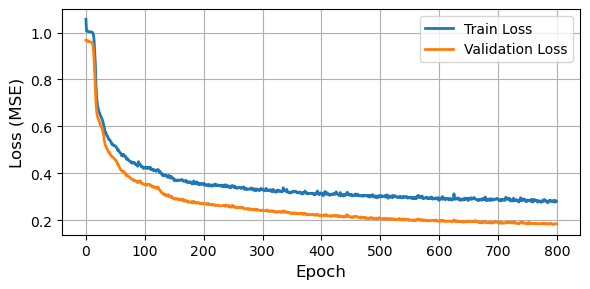

In [13]:
helper_functions.plot_metrics([(train_losses, "Train Loss"), (val_losses, "Validation Loss")], "Loss (MSE)")

In [15]:
torch.save(model.state_dict(), "CAE.pth")